In [1]:
using IntervalSets
using Distributions
using Random, LinearAlgebra, Statistics, Distributions, StatsBase, ArraysOfArrays
using JLD2
using ValueShapes
using Measurements
using TypedTables
using HypothesisTests
using LaTeXStrings
using HDF5
using CSV
using MultivariateStats

In [2]:
using Flux
using Flux: logitcrossentropy, normalise, onecold, onehotbatch, crossentropy, throttle
using Statistics: mean
using Parameters: @with_kw
using Flux: @epochs

In [3]:
# using PyPlot
using Plots
pyplot()

Plots.PyPlotBackend()

In [4]:
using PyPlot

In [5]:
using Revise
using BAT

In [6]:
PATH = "../data/Benchmark-3/"
filename = readdir("../data/Benchmark-3/")

mask_s = [i[end-3:end] == "hdf5" for i in filename]
samples_names = filename[mask_s];

In [7]:
prior = NamedTupleDist(a = [Uniform(-100,100) for i in 1:9]);

In [8]:
JLD2.@load "../data/mixture-9D-nc.jld" means cov_m n_clusters
mixture_model = MixtureModel(MvNormal[MvNormal(means[i,:], Matrix(Hermitian(cov_m[i,:,:])) ) for i in 1:n_clusters]);
iid_samples =  bat_sample(NamedTupleDist(a=mixture_model), 4*10^4).result;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Using sampling algorithm IIDSampling()
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44


In [9]:
samples_names[2]

"1-1-2.hdf5"

In [10]:
outp_tmp = bat_read("../data/Benchmark-3/"*samples_names[1])
sp_samples = varshape(prior).(outp_tmp);

In [11]:
sp_resampled = bat_sample(sp_samples, 4*10^4).result;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Using sampling algorithm OrderedResampling()
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44


In [12]:
# Plots.plot(sp_resampled)

# Test: IID vs. IID

In [13]:
# mixture_model_1 = MixtureModel(MvNormal[MvNormal(means[i,:], Matrix(Hermitian(cov_m[i,:,:])) ) for i in 1:1])
# iid_samples_1 =  bat_sample(NamedTupleDist(a=mixture_model_1), 5*10^4).result

# mixture_model_2 = MixtureModel(MvNormal[MvNormal(means[i,:], Matrix(Hermitian(cov_m[i,:,:])) ) for i in 1:2])
# iid_samples_2 =  bat_sample(NamedTupleDist(a=mixture_model_2), 5*10^4).result;

# data_a = flatview(unshaped.(iid_samples_1.v));
# data_b = flatview(unshaped.(iid_samples_2.v));

In [14]:
data_a = flatview(unshaped.(iid_samples.v));
data_b = flatview(unshaped.(sp_resampled.v));

In [15]:
x_d = hcat(data_a, data_b)

y_d = [repeat([0], size(data_a)[2]); repeat([1], size(data_b)[2])]
klasses = [0, 1]
onehot_labels = onehotbatch(y_d, klasses);

In [16]:
data_length = size(x_d)[2]

train_indices = [1:3:data_length; 2:3:data_length]
test_indices = collect(3:3:data_length)

x_train = x_d[:, train_indices]
y_train = onehot_labels[:,train_indices]

x_test = x_d[:, test_indices]
y_test = onehot_labels[:,test_indices]

2×26653 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     1  1  1  1  1  1  1  1  1  1  1  1

In [17]:
# train_data = Iterators.repeated((x_train, y_train), 100);

In [18]:
train_data = Flux.Data.DataLoader(x_train, y_train, batchsize=256, shuffle=true)

Flux.Data.DataLoader(([1.354002088462357 4.939416488102918 … -6.615867919327827 -3.0954448573489115; 16.191016524983194 8.910331538895548 … 2.823846472696124 -3.617482222050494; … ; 11.369284871902043 8.773461333499002 … 5.545141279566417 12.661827448799864; 16.371292512014985 5.951502294831697 … 7.744985677364337 5.398729788949737], Bool[1 1 … 0 0; 0 0 … 1 1]), 256, 53307, true, 53307, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  53298, 53299, 53300, 53301, 53302, 53303, 53304, 53305, 53306, 53307], true)

In [19]:
accuracy(x, y, model) = mean(onecold(model(x)) .== onecold(y))

accuracy (generic function with 1 method)

In [20]:
# Function to build confusion matrix
function confusion_matrix(X, y, model)
    ŷ = onehotbatch(onecold(model(X)), 0:1)
    # onecold([true, false, false], [:a, :b, :c]) -> :a
    # onehotbatch -> matrix of cathegorical variables
    y * transpose(ŷ)
end

confusion_matrix (generic function with 1 method)

In [21]:
# model = Chain(Flux.Dense(9, 2), softmax)
model = Chain(Flux.Dense(9, 20, sigmoid), Flux.Dense(20, 2), softmax)

# model = Chain(Dense(2, 3), Dense(3, 3))

Chain(Dense(9, 20, σ), Dense(20, 2), softmax)

In [22]:
# loss(x, y) = logitcrossentropy(model(x), y)

loss(x, y) = crossentropy(model(x), y) 

loss (generic function with 1 method)

In [23]:
loss_vector_test = Float64[]
loss_vector_train = Float64[]

evalcb = () -> begin 
    los_train = loss(x_train, y_train)
    lost_test = loss(x_test, y_test)
    push!(loss_vector_test, lost_test)
    push!(loss_vector_train, los_train)
    @info(los_train, lost_test)
end

#9 (generic function with 1 method)

In [24]:
# optimiser = Descent(0.5)
optimiser = ADAM()

ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}())

In [25]:
@time @epochs 200 Flux.train!(loss, Flux.params(model), train_data, optimiser, cb = throttle(evalcb, 80))

┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: 0.87679106
│   lost_test = 0.8735039
└ @ Main In[23]:9
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: 0.69777584
│   lost_test = 0.6986745
└ @ Main In[23]:9
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: 0.6936475
│   lost_test = 0.6946421
└ @ Main In[23]:9
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: 0.6919499
│   lost_test = 0.6929102
└ @ Main In[23]:9
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: 0.6910655
│   lost_test = 0.691918
└ @ Main In[23]:9
┌ Info: Epoch 6
└ @ Main /Users/vhafych/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: 0.6903944
│   lost_test = 0.69127524
└ @ Main In[23]:9
┌ Info: Epoch 7
└ @ Main /Users/vhafych/.julia/packages/Flux/Fj3bt/s

 65.968609 seconds (614.45 M allocations: 23.199 GiB, 5.46% gc time)


In [26]:
accuracy_score = accuracy(x_test, y_test, model)

0.5376505459047762

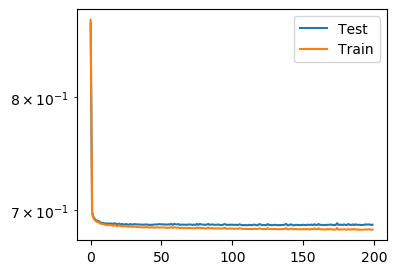

In [27]:
fig, ax = plt.subplots(1,1, figsize=(4,3))

ax.plot(loss_vector_test, label="Test")
ax.plot(loss_vector_train, label="Train")
ax.legend()
ax.set_yscale("log")

In [28]:
c_range = 0.0:0.002:1

function def_roc_vals(ind1, ind2; c_range = c_range)

    tA_array = Float64[]
    fA_array = Float64[]

    for c in c_range

        t_A = y_test[ind1,:]
        t_B = y_test[ind2,:]

        p = softmax(model(x_test), dims=1) .> c

        p_A = p[ind1,:]
        p_B = p[ind2,:]

        true_A = sum(t_A.*p_A)/sum(t_A)
        false_A = sum(.!t_A.*p_A) / sum(t_B)

        append!(tA_array, true_A)
        append!(fA_array, false_A)
    end
    
    return (fA_array, tA_array)
    
end

A_f, A_t = def_roc_vals(1, 2)

([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

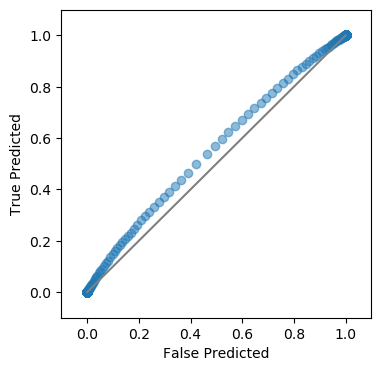

(-0.1, 1.1)

In [29]:
colors_a = plt.cm.terrain(range(0, stop=1, length = length(c_range)));

fig, ax = plt.subplots(1,1, figsize=(4,4))

ax.scatter(A_f, A_t, alpha=0.5, color=PyPlot.ColorMap("tab10").colors[1])

ax.plot(0:0.1:1, 0:0.1:1, color="gray")
ax.set_xlabel("False Predicted")
ax.set_ylabel("True Predicted")
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)

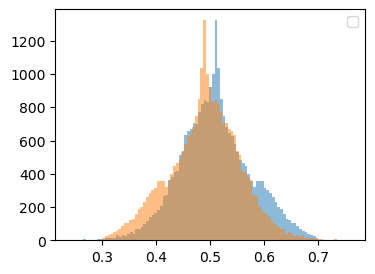

No handles with labels found to put in legend.


PyObject <matplotlib.legend.Legend object at 0x7fc271e88450>

In [30]:
fig, ax = plt.subplots(1,1, figsize=(4,3))

x_tmp = model(x_test)[1,:]
y_tmp = model(x_test)[2,:]
ax.hist(x_tmp, bins=100, alpha=0.5)
ax.hist(y_tmp, bins=100, alpha=0.5)

ax.legend()

In [31]:
ApproximateTwoSampleKSTest(x_tmp, y_tmp)

┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests /Users/vhafych/.julia/packages/HypothesisTests/5rgiE/src/kolmogorov_smirnov.jl:167


Approximate two sample Kolmogorov-Smirnov test
----------------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.116384647131655

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-99

Details:
    number of observations:   [26653,26653]
    KS-statistic:              13.435497300107537
